# Pynq-CV-OV5640 - Application Notebook

##### This reference design illustrates how to run a imgae processing IPs and implementate OV5640 camera interface on the **Programmable Logic (PL)** using Jupyter Notebooks and Python.
<img src="./images/SystemDiagram.png" width="800" height="650"/>

##### This PYNQ Overlay contains the below accelerated image processing algorithms.
- rgb2hsv	
- subsample
- equalizehist
- gaussianBlur
- sobel
- canny
- dilation
- erosion

##### The OV5640 video streaming, imgae processing IPs and HDMI interface are connected to PL DDR using VDMA and AXI4-stream-interconnect IPs, you can choose which image processing algorithm is enabled without downloading a new bitstream. In the example application notebook, you can configure the OV5640 camera and get the captured picture and display it on the notebook, configure the image processing IPs. The processed video streaming is displayed on the HDMI monitor which connected to the PL side.

     
## Image processing IPs interconnection
The image processing IPs are connected to VDMA using AXI4-stream-interconnect IP to transceive video streaming.
<img src="./images/ImageProcessing.PNG" width="800" height="650"/>


## Import libraries

In [1]:
from pynq import Overlay
from pynq.lib.iic import *
from ov5640_config import *
from pynq.lib.video import *
from time import sleep
import dma
import os
import shutil

## Instantiate Overlay and download bitstream

In [2]:
cv_ov5640 = Overlay("cv_ov5640.bit")

## Instantiate I2C and configure OV5640 Camera

In [3]:
iic = AxiIIC(cv_ov5640.ip_dict['axi_iic_0'])
address = 0x3c
length = 3

In [4]:
for config in ov5640_config:
    tmp1 = config[0] >> 8;
    tmp2 = config[0] & 0xff;
    iic.send(address, bytes([tmp1, tmp2, config[1]]), length)

# Check the attributes and methods in Overlay

In [5]:
#dir(cv_ov5640.image_processing)

## Configure image processing IPs

In [6]:
bayer2rgb = cv_ov5640.v_demosaic_0
bayer2rgb.write(0x10, 1280)
bayer2rgb.write(0x18, 720)
bayer2rgb.write(0x28, 1)
bayer2rgb.write(0x00, 0x81)

rgb2hsv = cv_ov5640.image_processing.rgb2hsv_0
rgb2hsv.write(0x10, 720)
rgb2hsv.write(0x18, 1280)
rgb2hsv.write(0x20, 0)
rgb2hsv.write(0x00, 0x81)

subsample = cv_ov5640.image_processing.subsample_0
subsample.write(0x10, 720)
subsample.write(0x18, 1280)
subsample.write(0x20, 360)
subsample.write(0x28, 640)
subsample.write(0x00, 0x81)

equalizehist = cv_ov5640.image_processing.equalizeHist_0
equalizehist.write(0x10, 720)
equalizehist.write(0x18, 1280)
equalizehist.write(0x20, 0)
equalizehist.write(0x00, 0x81)

gaussianBlur = cv_ov5640.image_processing.gaussian_0
gaussianBlur.write(0x10, 720)
gaussianBlur.write(0x18, 1280)
gaussianBlur.write(0x20, 0)
gaussianBlur.write(0x00, 0x81)

sobel = cv_ov5640.image_processing.sobelFilter_0
sobel.write(0x10, 720)
sobel.write(0x18, 1280)
sobel.write(0x20, 0)
sobel.write(0x00, 0x81)

canny = cv_ov5640.image_processing.canny_edge_0
canny.write(0x10, 720)
canny.write(0x18, 1280)
canny.write(0x20, 80)
canny.write(0x28, 80)
canny.write(0x00, 0x81)

dilation = cv_ov5640.image_processing.xf_dilation_accel_0
dilation.write(0x10, 720)
dilation.write(0x18, 1280)
dilation.write(0x20, 0)
dilation.write(0x00, 0x81)

erosion = cv_ov5640.image_processing.xf_erosion_accel_0
erosion.write(0x10, 720)
erosion.write(0x18, 1280)
erosion.write(0x20, 0)
erosion.write(0x00, 0x81)

switch0 = cv_ov5640.image_processing.axis_interconnect_0.xbar
switch1 = cv_ov5640.image_processing.axis_interconnect_1.xbar

# Define a function using to choose whtich image processing IP is enabled

In [7]:
def switch_stream(switch0, switch1, Index):
    MaxIndex = 5
    switch0.write(0x00, ~0x02)
    for i in range(0,MaxIndex + 1):
        switch0.write(0x40 + 4*Index, 0x80000000)
    switch0.write(0x40 + 4*Index, 0)
    switch0.write(0x00, 0x02)

    switch1.write(0x00, ~0x02)
    for i in range(0,MaxIndex + 1):
        switch0.write(0x40 + 4*Index, 0x80000000)
    switch1.write(0x40 + 4*0, Index)
    switch1.write(0x00, 0x02)
    
switch_stream(switch0, switch1, 0)

## Configure VDMAs

In [8]:
vdma0 = cv_ov5640.axi_vdma_0
vdma1 = cv_ov5640.axi_vdma_1

## Start VDMAs，HDMI monitor will display video streaming from OV5640 camera

In [9]:
vdma0.writechannel.mode = VideoMode(1280, 720, 24)
vdma1.readchannel.mode = vdma0.writechannel.mode
vdma0.readchannel.mode = vdma0.writechannel.mode
vdma1.writechannel.mode = vdma0.writechannel.mode
vdma0.readchannel.tie(vdma0.writechannel)
vdma1.readchannel.tie(vdma1.writechannel)
vdma0.writechannel.start()
vdma0.readchannel.start()
vdma1.writechannel.start()
vdma1.readchannel.start()

## Capture and display one frame of picture, it may takes 3~5 seconds

In [10]:
while True:
    frame = vdma0.readchannel.readframe()
    if(frame.max() != 0):
        break;

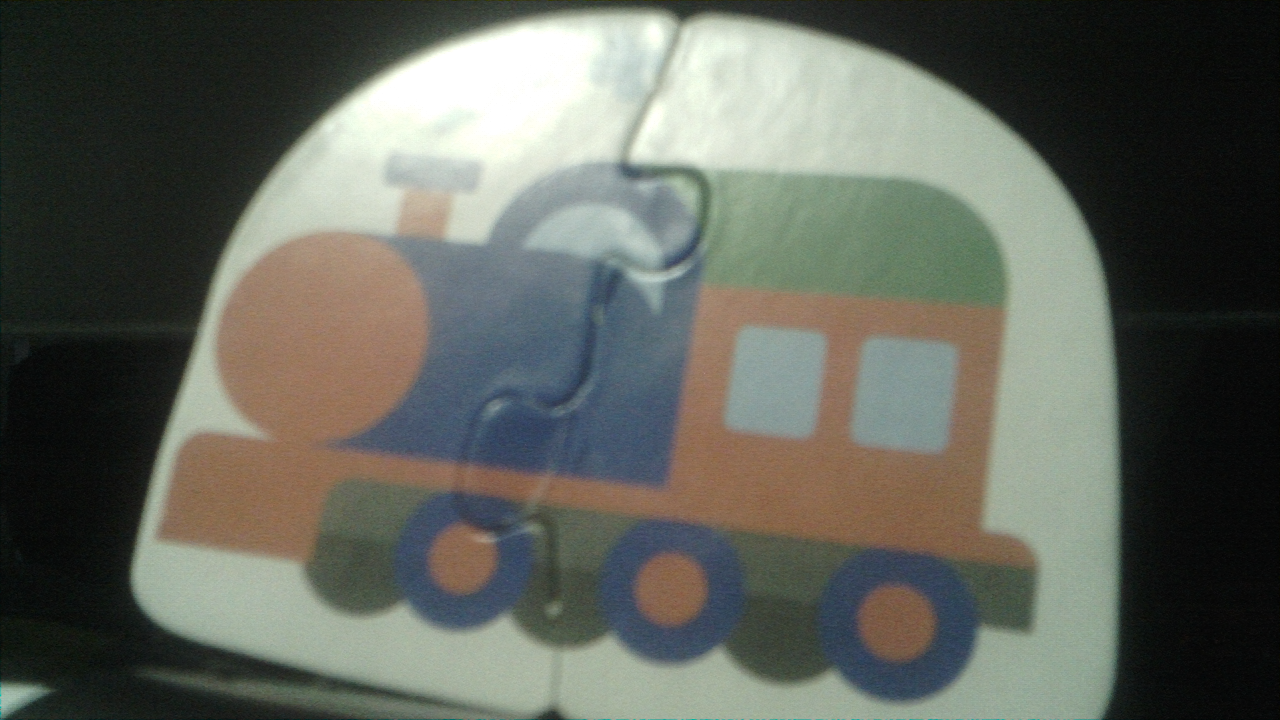

In [11]:
from PIL import Image
import IPython
image = Image.fromarray(frame)
g, b, r = image.split()
image = Image.merge('RGB', [r,g,b])
IPython.display.clear_output(1)
display(image)

## Enable different image processing IPs on PL

### Enable rgb2hsv IP

In [12]:
switch_stream(switch0, switch1, 1)

### Enable subsample IP

In [13]:
switch_stream(switch0, switch1, 2)
for i in range(len(vdma1.writechannel._frames)):
    vdma1.readchannel._frames[i].fill(0)
    vdma1.readchannel._frames[i].fill(0)

### Enable equalizehist IP

In [14]:
switch_stream(switch0, switch1, 3)

### Enable gaussianBlur IP

In [15]:
switch_stream(switch0, switch1, 4)

### Enable sobel x IP

In [16]:
switch_stream(switch0, switch1, 5)

### Enable sobel y IP

In [17]:
sobel.write(0x20, 1)

### Enable canny IP

In [18]:
switch_stream(switch0, switch1, 6)

### Enable dilation IP

In [19]:
switch_stream(switch0, switch1, 7)

### Enable erosion IP

In [20]:
switch_stream(switch0, switch1, 8)

### Disable all image processing IPs

In [21]:
switch_stream(switch0, switch1, 0)

## Close VDMAs

In [22]:
vdma0.writechannel.stop()
vdma0.readchannel.stop()
vdma1.writechannel.stop()
vdma1.readchannel.stop()